# Basic Chatbot

In [17]:
import os
import sys
import json
import datetime

from typing import Annotated
from typing_extensions import TypedDict

from IPython.display import Image, display
import networkx as nx

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import OpenAI, ChatOpenAI
from langchain_community.tools import TavilySearchResults
from langchain.chat_models import init_chat_model
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig, chain

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from lib.utils import set_chatgpt_env, set_langsmith_env, set_tavily_env

In [2]:
set_chatgpt_env()
set_langsmith_env()
set_tavily_env()

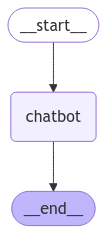

In [4]:
llm = ChatOpenAI(model='gpt-4-turbo')

class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

In [8]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    stream_graph_updates(user_input)

Assistant: Tullahoma is a city in Coffee and Franklin counties in the south-central part of Tennessee, United States. It serves as a major hub in the area largely due to its strategic location. The city’s history and development are tied to several key factors including transportation, military significance, and its role in local industry.

### Founding and Name Origin
Tullahoma was founded in 1852 as a work camp along the new Nashville and Chattanooga Railroad. The name "Tullahoma" is derived from the Choctaw words "tulla" meaning rock and "homa" meaning red, translating roughly to "red rock." This name may have been inspired by the red clay soil of the area.

### Civil War Significance
The city is perhaps best known historically for its role during the Civil War. In 1863, it became the headquarters for the Confederate Army of Tennessee under General Braxton Bragg. This was during a period known as the Tullahoma Campaign, which took place from June to July 1863. Despite its potential 

## Tavily Search

In [18]:
search_tool = TavilySearchResults(
    max_results=5,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
    # include_domains=[...],
    # exclude_domains=[...],
    # name="...",            # overwrite default tool name
    # description="...",     # overwrite default tool description
    # args_schema=...,       # overwrite default args_schema: BaseModel
)

In [6]:
search_tool.invoke({"query": "What happened at the last wimbledon"})

[{'url': 'https://www.nbcnews.com/news/sports/andy-murray-wimbledon-tennis-singles-draw-rcna159912',
  'content': "NBC News Now LONDON — Andy Murray, one of the last decade's most successful male tennis players, has pulled out of the singles tournament at what is almost certain to be his last Wimbledon, his team confirmed Tuesday. Murray, 37, who has won the Wimbledon singles title twice and the U.S Open once, has been battling to be fit to play at the All England Club for weeks. “Unfortunately, despite working incredibly hard on his recovery since his operation just over a week ago, Andy has taken the very difficult decision not to play the singles this year,” his team said in a statement reported by Sky News. The news caps a glittering career on the ATP singles tour, which placed Murray at No. 1 in the world for 41 weeks."},
 {'url': 'https://www.nytimes.com/athletic/live-blogs/wimbledon-2024-live-updates-alcaraz-djokovic-mens-final-result/kJJdTKhOgkZo/mGpXBR2QIift/',
  'content': "C

In [ ]:
# This is usually generated by a model, but we'll create a tool call directly for demo purposes.
model_generated_tool_call = {
    "args": {"query": "euro 2024 host nation"},
    "id": "1",
    "name": "tavily",
    "type": "tool_call",
}
tool_msg = search_tool.invoke(model_generated_tool_call)

# The content is a JSON string of results
print(tool_msg.content[:100])

[{"url": "https://footballgroundguide.com/euro-2024-host-nation", "content": "Eyes are on the Euro 2


In [8]:
# The artifact is a dict with richer, raw results
{k: type(v) for k, v in tool_msg.artifact.items()}

{'query': str,
 'follow_up_questions': NoneType,
 'answer': str,
 'images': list,
 'results': list,
 'response_time': float}

In [12]:
print(json.dumps({k: str(v)[:200] for k, v in tool_msg.artifact.items()}, indent=2))

{
  "query": "euro 2024 host nation",
  "follow_up_questions": "None",
  "answer": "Germany is the host nation for Euro 2024, with the tournament taking place from June 14 to July 14. The opening match will feature Germany against Scotland in Munich, followed by matches in various ci",
  "images": "['https://img.planetafobal.com/2021/10/sedes-uefa-euro-2024-alemania-fg.jpg', 'https://i.ytimg.com/vi/7qunL8ij1A0/maxresdefault.jpg', 'https://thepeninsulaqatar.com/get/maximage/20180927_1538055318-20",
  "results": "[{'title': 'Germany as a football destination: A guide to the Euro 2024 host nation', 'url': 'https://footballgroundguide.com/euro-2024-host-nation', 'content': 'Eyes are on the Euro 2024 host nation,",
  "response_time": "3.61"
}


### Chaining

In [19]:
llm = init_chat_model("gpt-4o-mini", model_provider="openai")

In [20]:
today = datetime.datetime.today().strftime("%D")
prompt = ChatPromptTemplate(
    [
        ("system", f"You are a helpful assistant. The date today is {today}."),
        ("human", "{user_input}"),
        ("placeholder", "{messages}"),
    ]
)

In [22]:
# specifying tool_choice will force the model to call this tool.
llm_with_tools = llm.bind_tools([search_tool])
llm_chain = prompt | llm_with_tools

@chain
def tool_chain(user_input: str, config: RunnableConfig):
    input_ = {"user_input": user_input}
    ai_msg = llm_chain.invoke(input_, config=config)
    tool_msgs = search_tool.batch(ai_msg.tool_calls, config=config)
    return llm_chain.invoke({**input_, "messages": [ai_msg, *tool_msgs]}, config=config)


tool_chain.invoke("who won the last womens singles wimbledon").content

"The last women's singles winner at Wimbledon, as of 2024, was Markéta Vondroušová, who won the title in 2023. She defeated Elina Svitolina in the final."

### Graphing